# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## split 

In [15]:
ds = dataset_cc.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27238
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6810
    })
})

In [16]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27238
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6810
})


## test dataset

In [17]:
notebook_login()

In [18]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [19]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [20]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [21]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [22]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [23]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

## label balance

<Axes: ylabel='count'>

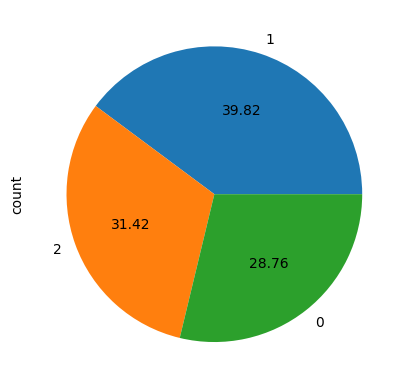

In [25]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

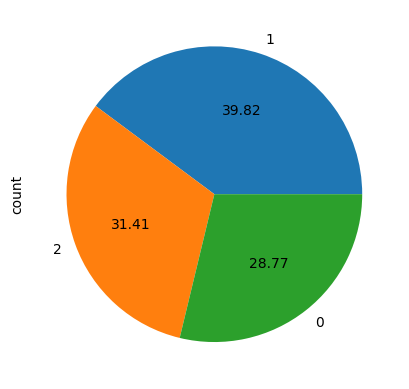

In [26]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

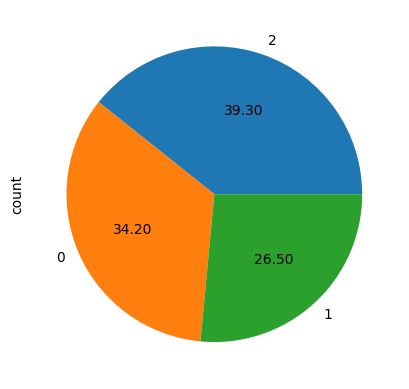

In [27]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

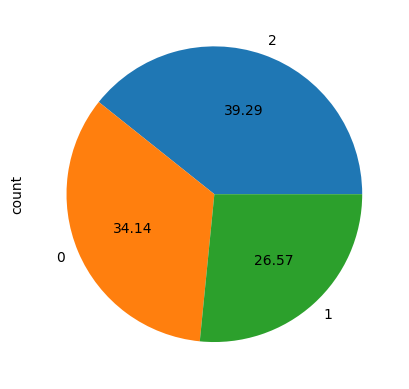

In [28]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [29]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27238
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6810
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})


In [30]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/27238 [00:00<?, ? examples/s]

Map:   0%|          | 0/6810 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [31]:
model_id="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"



# label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,
#                                                            id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

RobertaConfig {
  "_name_or_path": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [32]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/27238 [00:00<?, ? examples/s]

Map:   0%|          | 0/6810 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [33]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [34]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [35]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [36]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [37]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

In [39]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [40]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-07 10:07:30,881] A new study created in memory with name: no-name-7b94b340-a394-436d-bcc5-1722759220c4
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7857, 'learning_rate': 2.493270403814988e-06, 'epoch': 0.29}
{'eval_loss': 0.6489652991294861, 'eval_accuracy': 0.7327459618208517, 'eval_f1': 0.735037095759572, 'eval_precision': 0.7323545999319935, 'eval_recall': 0.7443307748164744, 'eval_runtime': 20.7423, 'eval_samples_per_second': 328.315, 'eval_steps_per_second': 41.076, 'epoch': 0.29}
{'loss': 0.6468, 'learning_rate': 2.2227919482047695e-06, 'epoch': 0.59}
{'eval_loss': 0.60545814037323, 'eval_accuracy': 0.745374449339207, 'eval_f1': 0.7482178756495553, 'eval_precision': 0.7460772032031101, 'eval_recall': 0.7578531987541993, 'eval_runtime': 20.7754, 'eval_samples_per_second': 327.791, 'eval_steps_per_second': 41.01, 'epoch': 0.59}
{'loss': 0.6323, 'learning_rate': 1.952313492594552e-06, 'epoch': 0.88}
{'eval_loss': 0.5802303552627563, 'eval_accuracy': 0.7525697503671072, 'eval_f1': 0.7552720889326365, 'eval_precision': 0.7529364342856165, 'eval_recall': 0.7593230545651152, 'eval_runtime': 20.8916, 'eval_samples_per_se

[I 2023-12-07 10:26:33,275] Trial 0 finished with value: 3.0863769359783846 and parameters: {'learning_rate': 2.7637488594252052e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.0863769359783846.


{'train_runtime': 1123.8733, 'train_samples_per_second': 72.707, 'train_steps_per_second': 4.546, 'train_loss': 0.597206266548424, 'epoch': 3.0}


eval/accuracy,▁▃▅▇▇▇█▇██
eval/f1,▁▃▅▆▇▇█▇██
eval/loss,█▅▃▂▁▁▁▁▁▁
eval/precision,▁▃▄▆▆▇█▇▇▇
eval/recall,▁▄▄▆▆▇████
eval/runtime,▁▂▃█▇▇▇▇▅▆
eval/samples_per_second,█▇▆▁▂▂▂▂▄▃
eval/steps_per_second,█▇▆▁▂▂▂▂▄▃
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁


{'loss': 0.8715, 'learning_rate': 1.450423060408295e-06, 'epoch': 0.29}
{'eval_loss': 0.6638449430465698, 'eval_accuracy': 0.7232011747430249, 'eval_f1': 0.7256011810540836, 'eval_precision': 0.7226908241342538, 'eval_recall': 0.7340882589309755, 'eval_runtime': 20.9882, 'eval_samples_per_second': 324.469, 'eval_steps_per_second': 40.594, 'epoch': 0.29}
{'loss': 0.6747, 'learning_rate': 1.3355289650020611e-06, 'epoch': 0.59}
{'eval_loss': 0.6271072626113892, 'eval_accuracy': 0.7348017621145374, 'eval_f1': 0.7373602118871361, 'eval_precision': 0.7353781353271159, 'eval_recall': 0.7476206920235753, 'eval_runtime': 21.0577, 'eval_samples_per_second': 323.397, 'eval_steps_per_second': 40.46, 'epoch': 0.59}
{'loss': 0.6571, 'learning_rate': 1.2206348695958277e-06, 'epoch': 0.88}
{'eval_loss': 0.5985791683197021, 'eval_accuracy': 0.7439060205580029, 'eval_f1': 0.7468795781400585, 'eval_precision': 0.7440162515222184, 'eval_recall': 0.751414277876458, 'eval_runtime': 21.0357, 'eval_samples_pe

[I 2023-12-07 10:51:12,325] Trial 1 finished with value: 3.073997858406822 and parameters: {'learning_rate': 1.5653171558145288e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.0863769359783846.


{'train_runtime': 1477.5041, 'train_samples_per_second': 73.741, 'train_steps_per_second': 4.61, 'train_loss': 0.6113315252997353, 'epoch': 4.0}


eval/accuracy,▁▃▄▅▆▇█▇▇▇███
eval/f1,▁▃▄▅▆▇█▇▇▇███
eval/loss,█▅▃▃▂▂▂▂▁▁▁▁▁
eval/precision,▁▃▄▅▆▇█▇▇▇▇██
eval/recall,▁▃▄▅▆▇▇▇▇████
eval/runtime,▁▃▂█▂▄▄▅▃▆▂▃▃
eval/samples_per_second,█▆▇▁▇▅▄▄▆▃▇▆▆
eval/steps_per_second,█▆▇▁▇▅▄▄▆▃▇▆▆
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇███
train/learning_rate,█▇▇▆▆▅▅▄▃▃▂▂▁


{'loss': 0.6748, 'learning_rate': 6.618223076289525e-06, 'epoch': 0.66}
{'eval_loss': 0.5646782517433167, 'eval_accuracy': 0.758590308370044, 'eval_f1': 0.7622276999186649, 'eval_precision': 0.7606624447744389, 'eval_recall': 0.7674992709090303, 'eval_runtime': 21.2228, 'eval_samples_per_second': 320.881, 'eval_steps_per_second': 40.145, 'epoch': 0.66}
{'loss': 0.5646, 'learning_rate': 5.610883186443326e-06, 'epoch': 1.32}
{'eval_loss': 0.5493424534797668, 'eval_accuracy': 0.7738619676945668, 'eval_f1': 0.7772882245685909, 'eval_precision': 0.7752808749868355, 'eval_recall': 0.7806269175695455, 'eval_runtime': 21.2025, 'eval_samples_per_second': 321.189, 'eval_steps_per_second': 40.184, 'epoch': 1.32}
{'loss': 0.5366, 'learning_rate': 4.603543296597128e-06, 'epoch': 1.98}
{'eval_loss': 0.5359029173851013, 'eval_accuracy': 0.7807635829662262, 'eval_f1': 0.784044459135425, 'eval_precision': 0.7856700701492317, 'eval_recall': 0.7826256213270996, 'eval_runtime': 21.2212, 'eval_samples_per_

[I 2023-12-07 11:14:06,656] Trial 2 finished with value: 3.1347278755887737 and parameters: {'learning_rate': 7.6255629661357235e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 36}. Best is trial 2 with value: 3.1347278755887737.


{'train_runtime': 1372.771, 'train_samples_per_second': 99.208, 'train_steps_per_second': 2.757, 'train_loss': 0.5196220730538412, 'epoch': 5.0}


eval/accuracy,▁▅▇▆▇█▇
eval/f1,▁▅▇▆▇█▇
eval/loss,█▄▁▃▄▃▅
eval/precision,▁▅█▆▆█▇
eval/recall,▁▅▆▆▇██
eval/runtime,▂▂▂▂▁█▅
eval/samples_per_second,▇▇▇▇█▁▄
eval/steps_per_second,▇▇▇▇█▁▄
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
train/learning_rate,█▇▆▅▃▂▁


{'loss': 1.108, 'learning_rate': 0.00013787318385167808, 'epoch': 0.73}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0914297103881836, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.2004, 'eval_samples_per_second': 321.221, 'eval_steps_per_second': 40.188, 'epoch': 0.73}


[I 2023-12-07 11:18:35,071] Trial 3 finished with value: 1.0541932570712664 and parameters: {'learning_rate': 0.0005187383326132197, 'num_train_epochs': 1, 'per_device_train_batch_size': 40}. Best is trial 2 with value: 3.1347278755887737.


{'train_runtime': 266.6521, 'train_samples_per_second': 102.148, 'train_steps_per_second': 2.554, 'train_loss': 1.1032334382313465, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.6568, 'learning_rate': 1.4408468254026828e-05, 'epoch': 0.44}
{'eval_loss': 0.5702816843986511, 'eval_accuracy': 0.7597650513950074, 'eval_f1': 0.7626871051515233, 'eval_precision': 0.7593073451280447, 'eval_recall': 0.7701201795305588, 'eval_runtime': 21.0797, 'eval_samples_per_second': 323.059, 'eval_steps_per_second': 40.418, 'epoch': 0.44}
{'loss': 0.5727, 'learning_rate': 3.0632176603049156e-06, 'epoch': 0.88}
{'eval_loss': 0.529930830001831, 'eval_accuracy': 0.779295154185022, 'eval_f1': 0.7827421346408436, 'eval_precision': 0.7820278979711283, 'eval_recall': 0.7835038271893167, 'eval_runtime': 21.1337, 'eval_samples_per_second': 322.235, 'eval_steps_per_second': 40.315, 'epoch': 0.88}


[I 2023-12-07 11:23:52,655] Trial 4 finished with value: 3.1275690139863106 and parameters: {'learning_rate': 2.5753718847748737e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 24}. Best is trial 2 with value: 3.1347278755887737.


{'train_runtime': 316.0721, 'train_samples_per_second': 86.177, 'train_steps_per_second': 3.591, 'train_loss': 0.6065374365987232, 'epoch': 1.0}


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▆▆█
train/global_step,▁▁▇▇█
train/learning_rate,█▁


{'loss': 1.1083, 'learning_rate': 0.0003674876380285995, 'epoch': 1.03}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-07 11:28:04,000] Trial 5 pruned. 


{'eval_loss': 1.0900933742523193, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.1976, 'eval_samples_per_second': 321.264, 'eval_steps_per_second': 40.193, 'epoch': 1.03}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.8983, 'learning_rate': 1.1482818901587988e-06, 'epoch': 0.44}


[I 2023-12-07 11:30:18,085] Trial 6 pruned. 


{'eval_loss': 0.6555045247077942, 'eval_accuracy': 0.7215859030837004, 'eval_f1': 0.7242206064137484, 'eval_precision': 0.7212318306004804, 'eval_recall': 0.7329696316639241, 'eval_runtime': 21.1468, 'eval_samples_per_second': 322.034, 'eval_steps_per_second': 40.29, 'epoch': 0.44}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.6537, 'learning_rate': 4.3718816140260466e-05, 'epoch': 0.66}
{'eval_loss': 0.5666943788528442, 'eval_accuracy': 0.7616740088105727, 'eval_f1': 0.7653911155133383, 'eval_precision': 0.7626454729235456, 'eval_recall': 0.7703523721244575, 'eval_runtime': 21.2073, 'eval_samples_per_second': 321.116, 'eval_steps_per_second': 40.175, 'epoch': 0.66}
{'loss': 0.5237, 'learning_rate': 3.1375841510034476e-05, 'epoch': 1.32}
{'eval_loss': 0.5495187640190125, 'eval_accuracy': 0.7779735682819383, 'eval_f1': 0.7817164587524311, 'eval_precision': 0.7824091389133501, 'eval_recall': 0.7827442694767616, 'eval_runtime': 21.1873, 'eval_samples_per_second': 321.419, 'eval_steps_per_second': 40.213, 'epoch': 1.32}
{'loss': 0.4599, 'learning_rate': 1.9032866879808483e-05, 'epoch': 1.98}
{'eval_loss': 0.5362574458122253, 'eval_accuracy': 0.7889867841409691, 'eval_f1': 0.7919201915772037, 'eval_precision': 0.7969029714857075, 'eval_recall': 0.7882101191400039, 'eval_runtime': 21.1137, 'eval_samples

[I 2023-12-07 11:44:08,232] Trial 7 finished with value: 3.1514321583427103 and parameters: {'learning_rate': 5.606179077048646e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 36}. Best is trial 7 with value: 3.1514321583427103.


{'train_runtime': 829.1881, 'train_samples_per_second': 98.547, 'train_steps_per_second': 2.739, 'train_loss': 0.4788167559591383, 'epoch': 3.0}


eval/accuracy,▁▅█▇
eval/f1,▁▅█▇
eval/loss,▅▃▁█
eval/precision,▁▅█▆
eval/recall,▁▆██
eval/runtime,█▇▁▃
eval/samples_per_second,▁▂█▆
eval/steps_per_second,▁▂█▆
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 1.1115, 'learning_rate': 0.0005318519817236772, 'epoch': 0.88}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-07 11:47:50,493] Trial 8 pruned. 


{'eval_loss': 1.0890920162200928, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.137, 'eval_samples_per_second': 322.183, 'eval_steps_per_second': 40.308, 'epoch': 0.88}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.1178, 'learning_rate': 0.0005354930841132027, 'epoch': 0.59}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-07 11:50:33,532] Trial 9 pruned. 


{'eval_loss': 1.0896177291870117, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.0647, 'eval_samples_per_second': 323.29, 'eval_steps_per_second': 40.447, 'epoch': 0.59}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.6733, 'learning_rate': 6.01737408697463e-05, 'epoch': 0.66}
{'eval_loss': 0.5711100101470947, 'eval_accuracy': 0.7622613803230543, 'eval_f1': 0.7661813539592442, 'eval_precision': 0.7687967956819439, 'eval_recall': 0.7658921662613237, 'eval_runtime': 21.159, 'eval_samples_per_second': 321.849, 'eval_steps_per_second': 40.267, 'epoch': 0.66}
{'loss': 0.5232, 'learning_rate': 3.0502271012869424e-05, 'epoch': 1.32}
{'eval_loss': 0.5577861070632935, 'eval_accuracy': 0.7801762114537445, 'eval_f1': 0.7833840706779904, 'eval_precision': 0.7842957720077967, 'eval_recall': 0.7835327786334938, 'eval_runtime': 21.1633, 'eval_samples_per_second': 321.783, 'eval_steps_per_second': 40.258, 'epoch': 1.32}
{'loss': 0.4492, 'learning_rate': 8.308011559925525e-07, 'epoch': 1.98}
{'eval_loss': 0.5460180640220642, 'eval_accuracy': 0.7857562408223201, 'eval_f1': 0.7890849589048966, 'eval_precision': 0.7887070572067133, 'eval_recall': 0.7903064015320181, 'eval_runtime': 21.1415, 'eval_samples_per

[I 2023-12-07 12:00:03,091] Trial 10 finished with value: 3.153854658465948 and parameters: {'learning_rate': 8.984521072662317e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 10 with value: 3.153854658465948.


{'train_runtime': 568.4172, 'train_samples_per_second': 95.838, 'train_steps_per_second': 2.664, 'train_loss': 0.5474575302874869, 'epoch': 2.0}


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▄▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▇█▁
eval/samples_per_second,▂▁█
eval/steps_per_second,▂▁█
train/epoch,▁▁▄▄███
train/global_step,▁▁▄▄███
train/learning_rate,█▅▁


{'loss': 0.6656, 'learning_rate': 5.352776234709051e-05, 'epoch': 0.66}
{'eval_loss': 0.5639870166778564, 'eval_accuracy': 0.76784140969163, 'eval_f1': 0.7715047498501587, 'eval_precision': 0.7706369925490836, 'eval_recall': 0.7731409889339207, 'eval_runtime': 21.1518, 'eval_samples_per_second': 321.958, 'eval_steps_per_second': 40.28, 'epoch': 0.66}
{'loss': 0.5203, 'learning_rate': 2.7133402215389073e-05, 'epoch': 1.32}
{'eval_loss': 0.548395574092865, 'eval_accuracy': 0.7819383259911894, 'eval_f1': 0.7856087203373846, 'eval_precision': 0.7890524948902939, 'eval_recall': 0.7841759904472024, 'eval_runtime': 21.1794, 'eval_samples_per_second': 321.539, 'eval_steps_per_second': 40.228, 'epoch': 1.32}
{'loss': 0.4449, 'learning_rate': 7.390420836876402e-07, 'epoch': 1.98}
{'eval_loss': 0.5478613376617432, 'eval_accuracy': 0.7872246696035242, 'eval_f1': 0.790323794130409, 'eval_precision': 0.7898008608518875, 'eval_recall': 0.7912247815521681, 'eval_runtime': 21.1923, 'eval_samples_per_se

[I 2023-12-07 12:09:31,600] Trial 11 finished with value: 3.158574106137989 and parameters: {'learning_rate': 7.992212247879194e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 11 with value: 3.158574106137989.


{'train_runtime': 566.8961, 'train_samples_per_second': 96.095, 'train_steps_per_second': 2.671, 'train_loss': 0.5425239154180731, 'epoch': 2.0}


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▁▁
eval/precision,▁██
eval/recall,▁▅█
eval/runtime,▁▆█
eval/samples_per_second,█▃▁
eval/steps_per_second,█▃▁
train/epoch,▁▁▄▄███
train/global_step,▁▁▄▄███
train/learning_rate,█▅▁


{'loss': 0.6836, 'learning_rate': 7.383137721381757e-05, 'epoch': 0.66}
{'eval_loss': 0.5869103670120239, 'eval_accuracy': 0.7629955947136564, 'eval_f1': 0.7658891956564519, 'eval_precision': 0.7701899938267375, 'eval_recall': 0.7629603320806492, 'eval_runtime': 21.1205, 'eval_samples_per_second': 322.435, 'eval_steps_per_second': 40.34, 'epoch': 0.66}
{'loss': 0.5318, 'learning_rate': 3.742537267051502e-05, 'epoch': 1.32}


[I 2023-12-07 12:15:36,906] Trial 12 pruned. 


{'eval_loss': 0.5662793517112732, 'eval_accuracy': 0.7701908957415565, 'eval_f1': 0.7737656601454942, 'eval_precision': 0.7736737697626125, 'eval_recall': 0.7762385878131934, 'eval_runtime': 21.1016, 'eval_samples_per_second': 322.725, 'eval_steps_per_second': 40.376, 'epoch': 1.32}


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁██
train/global_step,▁▁██
train/learning_rate,█▁


{'loss': 0.6282, 'learning_rate': 5.923987097834508e-05, 'epoch': 1.17}
{'eval_loss': 0.6173745393753052, 'eval_accuracy': 0.7637298091042585, 'eval_f1': 0.7654265744455255, 'eval_precision': 0.7639746719624977, 'eval_recall': 0.7770277239445488, 'eval_runtime': 21.1071, 'eval_samples_per_second': 322.64, 'eval_steps_per_second': 40.366, 'epoch': 1.17}


[I 2023-12-07 12:23:33,156] Trial 13 finished with value: 3.0701587794568304 and parameters: {'learning_rate': 0.00014338741498167614, 'num_train_epochs': 2, 'per_device_train_batch_size': 64}. Best is trial 11 with value: 3.158574106137989.


{'train_runtime': 474.6404, 'train_samples_per_second': 114.773, 'train_steps_per_second': 1.795, 'train_loss': 0.5544512036820533, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.596, 'learning_rate': 9.37189995655757e-06, 'epoch': 1.32}
{'eval_loss': 0.5421528220176697, 'eval_accuracy': 0.7812041116005873, 'eval_f1': 0.7848404276046098, 'eval_precision': 0.7843484907090169, 'eval_recall': 0.7860222773338986, 'eval_runtime': 21.2168, 'eval_samples_per_second': 320.973, 'eval_steps_per_second': 40.157, 'epoch': 1.32}


[I 2023-12-07 12:38:57,244] Trial 14 finished with value: 3.1364153072481127 and parameters: {'learning_rate': 2.7534496771591617e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 72}. Best is trial 11 with value: 3.158574106137989.


{'train_runtime': 922.4252, 'train_samples_per_second': 59.057, 'train_steps_per_second': 0.822, 'train_loss': 0.5602056961260874, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.7457, 'learning_rate': 6.697849863918033e-05, 'epoch': 0.66}


[I 2023-12-07 12:41:55,256] Trial 15 pruned. 


{'eval_loss': 0.6215859055519104, 'eval_accuracy': 0.7430249632892805, 'eval_f1': 0.74741650615496, 'eval_precision': 0.7507889236625854, 'eval_recall': 0.7504137932195306, 'eval_runtime': 21.1004, 'eval_samples_per_second': 322.742, 'eval_steps_per_second': 40.378, 'epoch': 0.66}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.6437, 'learning_rate': 3.2682453432050665e-05, 'epoch': 0.66}
{'eval_loss': 0.5628186464309692, 'eval_accuracy': 0.7654919236417034, 'eval_f1': 0.7692255991400102, 'eval_precision': 0.7681870842379843, 'eval_recall': 0.7749969225181624, 'eval_runtime': 21.1455, 'eval_samples_per_second': 322.055, 'eval_steps_per_second': 40.292, 'epoch': 0.66}
{'loss': 0.5158, 'learning_rate': 1.656684523084225e-05, 'epoch': 1.32}
{'eval_loss': 0.5398746132850647, 'eval_accuracy': 0.781791483113069, 'eval_f1': 0.7854725962008224, 'eval_precision': 0.7866328244905034, 'eval_recall': 0.7863078667825357, 'eval_runtime': 21.1305, 'eval_samples_per_second': 322.283, 'eval_steps_per_second': 40.321, 'epoch': 1.32}
{'loss': 0.4511, 'learning_rate': 4.5123702963383563e-07, 'epoch': 1.98}
{'eval_loss': 0.5377259850502014, 'eval_accuracy': 0.7878120411160059, 'eval_f1': 0.7908986687948932, 'eval_precision': 0.7898266130446197, 'eval_recall': 0.7923763892683207, 'eval_runtime': 21.1425, 'eval_samples_p

[I 2023-12-07 12:51:22,225] Trial 16 finished with value: 3.1609137122238393 and parameters: {'learning_rate': 4.879806163325908e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 16 with value: 3.1609137122238393.


{'train_runtime': 566.0114, 'train_samples_per_second': 96.245, 'train_steps_per_second': 2.675, 'train_loss': 0.5359443371015622, 'epoch': 2.0}


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▆█
eval/runtime,█▁▇
eval/samples_per_second,▁█▂
eval/steps_per_second,▁█▂
train/epoch,▁▁▄▄███
train/global_step,▁▁▄▄███
train/learning_rate,█▄▁


{'loss': 0.6562, 'learning_rate': 5.247286063151943e-06, 'epoch': 0.59}


[I 2023-12-07 12:54:05,334] Trial 17 pruned. 


{'eval_loss': 0.578296422958374, 'eval_accuracy': 0.7569750367107195, 'eval_f1': 0.7599817256942639, 'eval_precision': 0.7570287840280033, 'eval_recall': 0.7682144430421122, 'eval_runtime': 21.0836, 'eval_samples_per_second': 322.999, 'eval_steps_per_second': 40.41, 'epoch': 0.59}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5818, 'learning_rate': 1.6534797190948834e-05, 'epoch': 1.32}
{'eval_loss': 0.5464564561843872, 'eval_accuracy': 0.7837004405286344, 'eval_f1': 0.7867736501275457, 'eval_precision': 0.7859892227730656, 'eval_recall': 0.7876635860211811, 'eval_runtime': 20.7516, 'eval_samples_per_second': 328.167, 'eval_steps_per_second': 41.057, 'epoch': 1.32}


[I 2023-12-07 13:10:16,659] Trial 18 finished with value: 3.144126899450427 and parameters: {'learning_rate': 4.8578977793562855e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 72}. Best is trial 16 with value: 3.1609137122238393.


{'train_runtime': 970.3545, 'train_samples_per_second': 56.14, 'train_steps_per_second': 0.781, 'train_loss': 0.5408252927432903, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.8291, 'learning_rate': 0.00018829269047739006, 'epoch': 0.73}


[I 2023-12-07 13:13:30,217] Trial 19 pruned. 


{'eval_loss': 0.7265196442604065, 'eval_accuracy': 0.6976505139500734, 'eval_f1': 0.699009957214232, 'eval_precision': 0.7043621418390873, 'eval_recall': 0.7167520523738412, 'eval_runtime': 21.1185, 'eval_samples_per_second': 322.466, 'eval_steps_per_second': 40.344, 'epoch': 0.73}


BestRun(run_id='16', objective=3.1609137122238393, hyperparameters={'learning_rate': 4.879806163325908e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}, run_summary=None)

# Trainer

In [36]:
training_args = TrainingArguments(
    output_dir='./4results',          # output directory
    learning_rate= 4.879806163325908e-05,
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=36,  # batch size per device during training
    per_device_eval_batch_size=36,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.760400,0.663004,0.733333,0.733670,0.736734,0.752713
200,0.651100,0.575440,0.765345,0.769180,0.767640,0.771421
300,0.604000,0.560658,0.771072,0.774302,0.773257,0.775642
400,0.578300,0.588486,0.751248,0.753287,0.754133,0.763537
500,0.581900,0.547829,0.769604,0.772378,0.783345,0.766566
600,0.590700,0.537804,0.772687,0.776463,0.789073,0.769217
700,0.571400,0.555437,0.765932,0.768431,0.771595,0.769299
800,0.492600,0.547233,0.775330,0.778498,0.777004,0.780775
900,0.462800,0.542941,0.777680,0.781381,0.780652,0.783110
1000,0.448400,0.566258,0.780764,0.783923,0.784028,0.783986


# Confusion matrix

In [47]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [48]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [49]:
preds_output.metrics

{'test_loss': 0.9674354791641235,
 'test_accuracy': 0.655,
 'test_f1': 0.6454303822650969,
 'test_precision': 0.7031606248900583,
 'test_recall': 0.6453182823430782,
 'test_runtime': 2.8324,
 'test_samples_per_second': 353.054,
 'test_steps_per_second': 9.886}

In [50]:
y_preds = np.argmax(preds_output.predictions, axis=1)

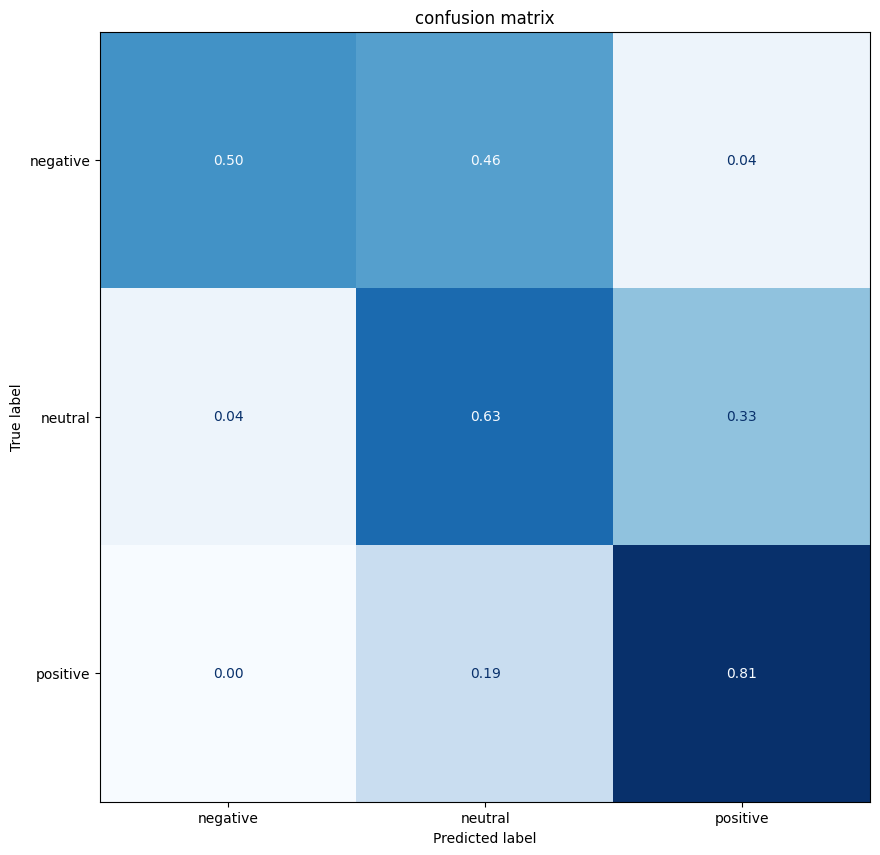

In [51]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [52]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [53]:
preds_output.metrics

{'test_loss': 0.5402624011039734,
 'test_accuracy': 0.781791483113069,
 'test_f1': 0.7854972964513909,
 'test_precision': 0.7852506921563812,
 'test_recall': 0.7858954552830791,
 'test_runtime': 18.2367,
 'test_samples_per_second': 373.423,
 'test_steps_per_second': 10.419}

In [54]:
y_preds = np.argmax(preds_output.predictions, axis=1)

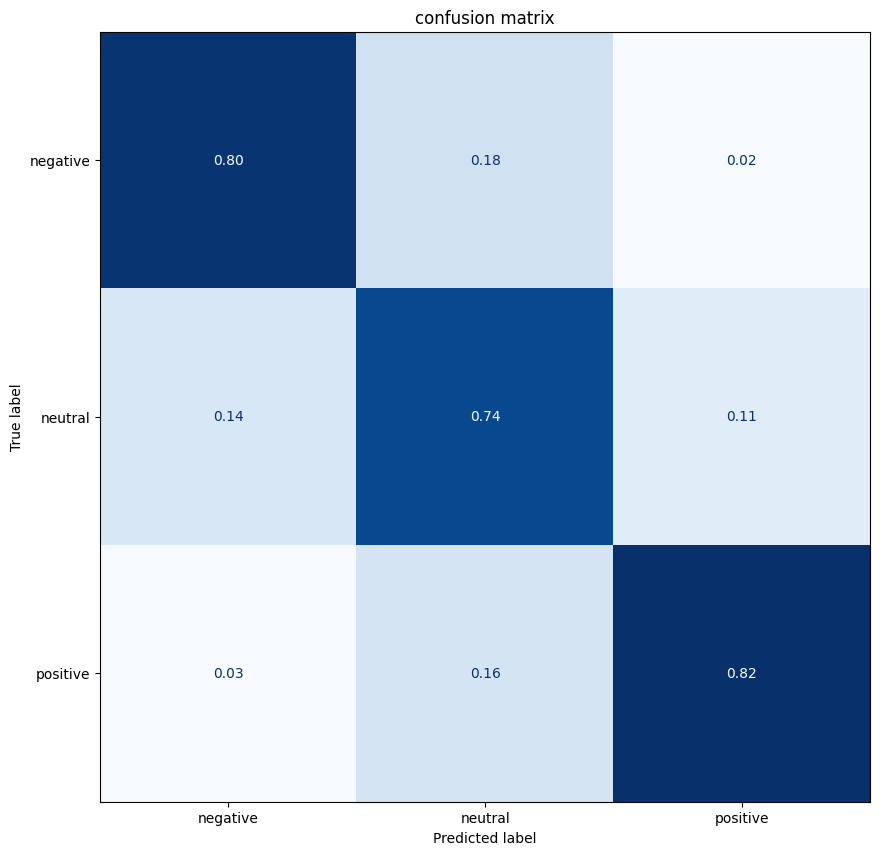

In [55]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

# Notify

In [56]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>